# Processing Sequences Using RNNs and CNNs

- Reading: Geron ch.15

- Recurrent neural networks (RNNs) are a class of ANN that attempt to predict the future.

- RNNs can analyze time series data
  - the number of daily active users on your website, the hourly temperature in your city, your home's daily power consumption, the trajectories of nearby cars, and more.
  
- Once an RNN
learns past patterns in the data, it is able to use its knowledge to forecast the future,
assuming of course that past patterns still hold in the future...

- RNNs can work on sequences of arbitrary lengths, rather than on fixed-sized inputs.

#### Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import numpy as np
import pandas as pd
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/rnn` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
      plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [5]:
if not tf.config.list_physical_devices('GPU'):
  print("No GPU was detected. Neural nets can be very slow without a GPU.")
  if "google.colab" in sys.modules:
    print("Go to Runtime > Change runtime and select a GPU hardware "
          "accelerator.")
  if "kaggle_secrets" in sys.modules:
    print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


# Cross-validation of time series data

- Time series data is characterized by the correlation between observations that are near in time (autocorrelation).
- Classical cross-validation techniques such as `KFold` and `ShuffleSplit` assume the samples are independent and identically distributed
    - Using them for time series would result in unreasonable correlation between training and testing instances **yielding poor estimates of generalization error**
    
- It is very important to evaluate our model for time series data on the "future" observations


### Time Series Split

`TimeSeriesSplit` is a variation of k-fold which returns first $k$ folds as train set and the $(k+1)$th fold as test set

    - Unlike standard cross-validation methods, successive training sets are supersets of those that come before them
    


In [6]:
from sklearn.model_selection import TimeSeriesSplit

In [7]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0]
  Test:  index=[1]
Fold 1:
  Train: index=[0 1]
  Test:  index=[2]
Fold 2:
  Train: index=[0 1 2]
  Test:  index=[3]
Fold 3:
  Train: index=[0 1 2 3]
  Test:  index=[4]
Fold 4:
  Train: index=[0 1 2 3 4]
  Test:  index=[5]


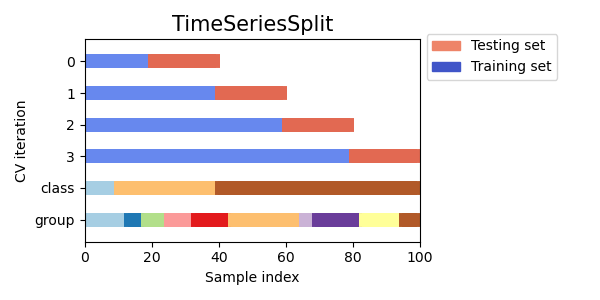

In [8]:
# Fix test_size to 2 with 12 samples
X = np.random.randn(12, 2)
y = np.random.randint(0, 2, 12)
tscv = TimeSeriesSplit(n_splits=3, test_size=2)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    

Fold 0:
  Train: index=[0 1 2 3 4 5]
  Test:  index=[6 7]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[8 9]
Fold 2:
  Train: index=[0 1 2 3 4 5 6 7 8 9]
  Test:  index=[10 11]


In [6]:
# Add in a 2 period gap
tscv = TimeSeriesSplit(n_splits=3, test_size=2, gap=2)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 1 2 3]
  Test:  index=[6 7]
Fold 1:
  Train: index=[0 1 2 3 4 5]
  Test:  index=[8 9]
Fold 2:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[10 11]


# Recurrent Neurons and Layers

- Up to now we have focused on feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer.

- A **recurrent** neural network looks very much like a feedforward neural network, except it also has **connections pointing backward**!

#### The simplest possible RNN

- A RNN composed of one neuron receiving inputs,
producing an output, and sending that output back to itself:

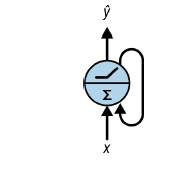

- At each time step $t$ (also called a *frame*), this recurrent neuron receives the inputs $x_{(t)}$ as well as its own output from the previous time step, $ŷ_{(t–1)}$.

  - Since there is no previous output at the first time step, it is generally set to 0.

- We can represent this tiny network against the time axis. This is called *unrolling the network through time*.

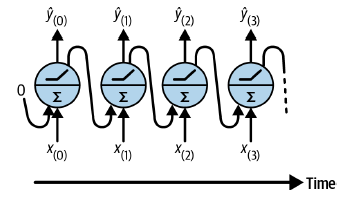

#### A layer of recurrent neurons

- At each time step $t$, every neuron receives both the input **vector** $\boldsymbol x_{(t)}$ and the output **vector** from the previous time step $\hat{\boldsymbol y}_{(t–1)}$.

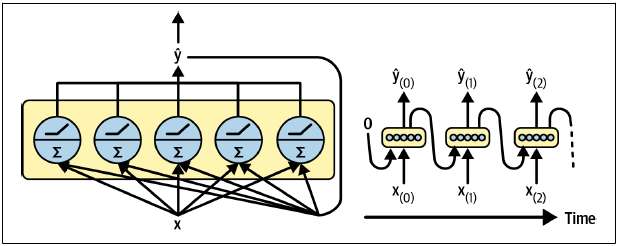

- Each recurrent neuron has two sets of weights: one for the inputs $\mathbf x_{(t)}$ and the other for the outputs of the previous time step, $\hat{\mathbf y}_{(t–1)}$.
  - Weight vectors $\mathbf w_x$ and $\mathbf w_ŷ$
  - If we consider the whole recurrent layer instead of just one recurrent neuron, we can
place all the weight vectors in **two weight matrices**: $\mathbf W_x$ and $\mathbf W_ŷ$.

- The output vector of the whole recurrent layer can then be computed:

$$\hat{\mathbf y}_{(t)}=\varphi \left(\mathbf{W}_x^\intercal \mathbf{x}_{(t)}+ \mathbf{W}_ŷ^\intercal \hat{\mathbf{y}}_{(t-1)} + \mathbf b \right)$$

where $\mathbf b$ is the bias vector and $\varphi(·)$ is the activation function (e.g., ReLU).

#### Memory Cells

- Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of *memory*.

- A part of a neural network that preserves some state across time steps is called a *memory cell*.

  - A single recurrent neuron, or a layer of recurrent neurons, is a very basic cell, capable of learning only short patterns.
  
- A cell's state at time step $t$, denoted $\mathbf h_{(t)}$ (the “h” stands for “hidden”), is a function of some inputs at that time step and its state at the previous time step:

$$ \mathbf h_{(t)} = f\left(\mathbf x_{(t)}, \mathbf h_{(t–1)} \right)$$


- Its output at time step $t$, denoted $\hat{\mathbf y}_{(t)}$, is also a function of the previous state and the current inputs. In the case of the basic cells we have discussed so far, the output is just equal to the state, but in more complex cells this is not always the case.

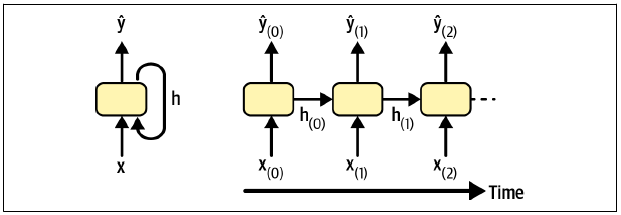

### Input and Output Sequences

1. An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs.

  - This type of **sequence-to-sequence** network is useful to forecast time series, such as your home's daily power consumption.
  - You feed the network the data over the last $N$ days, and you train it to output the power consumption shifted by one day into the future (i.e., from $N-1$ days ago to tomorrow).

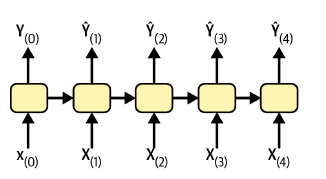


2. Alternatively, you could feed the network a sequence of inputs and ignore all outputs except for the last one.
  - This is a **sequence-to-vector** network.
  - For example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from 0 [hate] to 1 [love]).

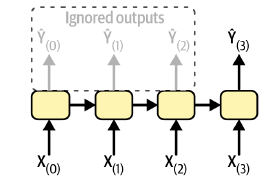


3. Conversely, you could feed the network the same input vector over and over again at each time step and let it output a sequence.
  - This is a **vector-to-sequence network**.
  - For example, the input could be an image (or the output of a CNN), and the output could be a caption for that image.

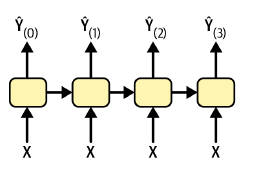

4. Lastly, you could have a sequence-to-vector network, called an **encoder**, followed by a vector-to-sequence network, called a **decoder**.

  - For example, this could be used for translating a sentence from one language to another.
  - You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language.

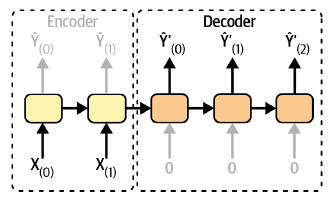

### Training RNNs

- To train an RNN, the trick is to unroll it through time (like we just did) and then use regular backpropagation.

- This strategy is called **backpropagation through time (BPTT)**.

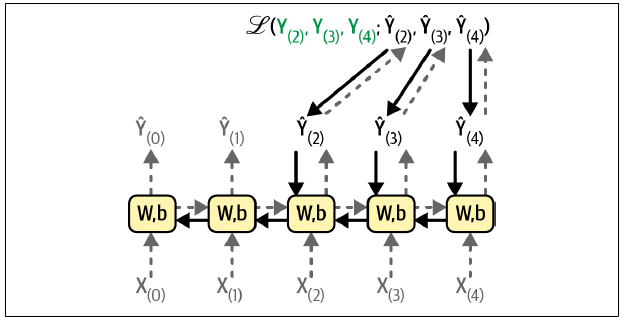

- Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows).

- Then the output sequence is evaluated
using a loss function:
$$ℒ\left(\mathbf Y_{(0)}, \mathbf Y_{(1)}, \ldots, \mathbf Y_{(T)}; \hat{\mathbf Y}_{(0)}, \hat{\mathbf Y}_{(1)}, \ldots, \hat{\mathbf Y}_{(T)}\right)$$

 where $\mathbf Y_{(i)}$ is the $i^{th}$ target, $\hat{\mathbf Y}_{(i)}$ is the $i^{th}$ prediction, and $T$ is the max time step.

  - The loss function may ignore some outputs.
  - For example, in a sequence-to-vector RNN, all
outputs are ignored except for the very last one.

- The gradients of the loss function are then propagated backward through the unrolled network (represented by the solid arrows).

- Since the same parameters $\mathbf W$ and $\mathbf b$ are used at each time step, their gradients will be tweaked multiple times during backprop.

- Once the backward phase is complete and all the gradients have been computed, BPTT can perform a gradient descent step to update the parameters.

## Forecasting a Time Series

- We will build a model capable of forecasting the number of passengers that will ride on bus and rail the next day in Chicago.

- We have access to daily ridership data since 2001.
- Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority.

In [9]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


'.\\datasets\\ridership_extracted'

In [5]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [6]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [7]:
df.day_type.value_counts()

W    5336
U    1216
A    1087
Name: day_type, dtype: int64

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

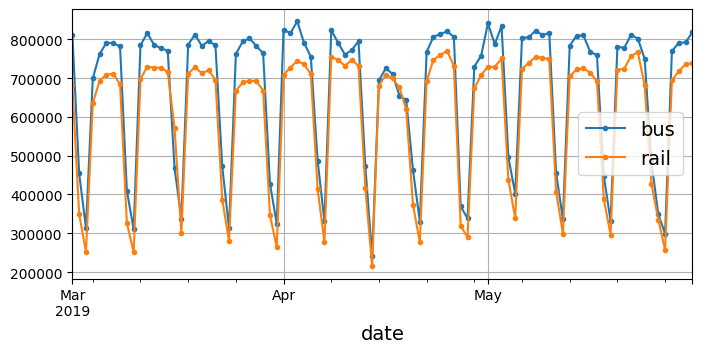

In [14]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

- A similar pattern is clearly repeated every week.
  - **weekly seasonality**
  
- Seasonality is so strong in this case that forecasting tomorrow's ridership by just copying the values from a week earlier will
yield reasonably good results.
  - This is called **naive forecasting**: simply copying a past value to make our forecast.
  
- Naive forecasting is often a great baseline, and it can even be tricky to beat in some cases.

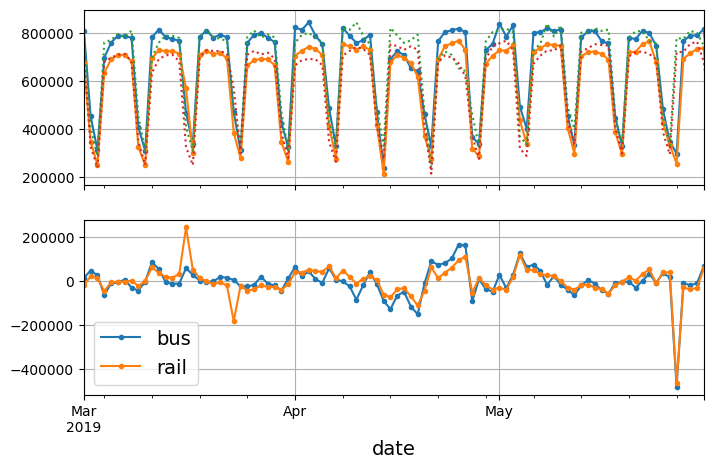

In [15]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

- When a time series is correlated with a lagged version of itself, we say that the time
series is **autocorrelated**.

- As you can see, most of the differences are fairly small, except at the end of May. Maybe there was a holiday at that time?

In [16]:
# Long weekend!
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [17]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [18]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

- There doesn't appear to be any significant monthly seasonality

- Now let's look at the yearly seasonality and the long-term trends:

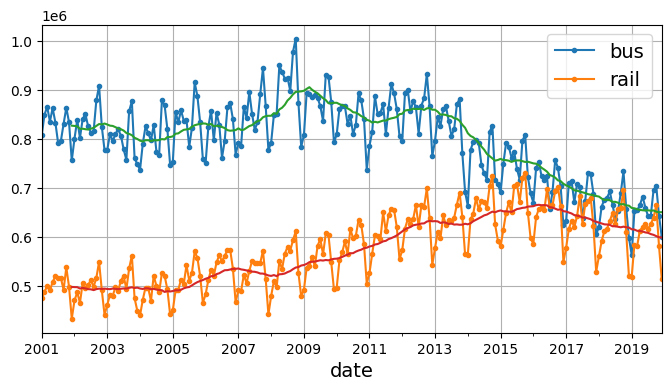

In [19]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean(numeric_only=True)  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

- There's definitely some yearly seasonality, although it is noisier than the weekly seasonality, and more visible for the rail series than the bus series: we see
peaks and troughs at roughly the same dates each year

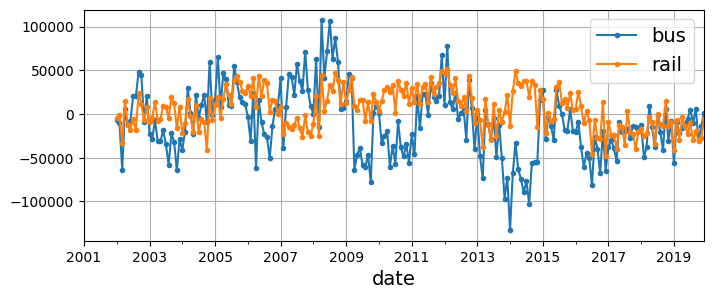

In [20]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

- Differencing not only removed the yearly seasonality, but it also removed the long-term trends.

- It's easier to study a **stationary** time series, meaning one whose statistical properties remain constant over time, without any seasonality or trends.

- It's easy to turn forecasts on the differenced time series into forecasts for the actual time series by just adding back the past values that were previously subtracted.

## The ARMA Model Family

- The autoregressive moving average (ARMA) model computes its forecasts using a simple weighted sum of lagged values and corrects these forecasts by adding a moving average, very much
like we just discussed.

- Specifically, the moving average component is computed using a weighted sum of the last few forecast errors.

$$\hat{y}_{(t)}= \sum_{t=1}^{p} \alpha_i y_{(t-i)} + \sum_{t=1}^{q} \theta_i \epsilon_{(t-i)} \\
\text{with }\epsilon_{(t)}=y_{(t)}-\hat{y}_{(t)}$$

  - $p$ and $q$ are hyperparameters that determine how far back into the past the model should look.

- Importantly, the model assumes that the time series is stationary. If it is not, then
differencing may help (ARIMA).

- The seasonal ARIMA (SARIMA) model additionally models a seasonal component for a given frequency (e.g., weekly), using the exact same
ARIMA approach.
  - It has a total of seven hyperparameters: the same $p$, $d$, and $q$ hyperparameters as ARIMA, plus additional $P$, $D$, and $Q$ hyperparameters to model the seasonal pattern, and lastly the period of the seasonal pattern, noted $s$.


- The `statsmodels` library fits SARIMA models

In [21]:
if "google.colab" in sys.modules:
  %pip install -q -U statsmodels

We will fit a SARIMA model to the rail time series, and use it to make a forecast for tomorrow's ridership.
- We'll pretend today is the last day of May 2019, and we want to forecast the rail ridership for “tomorrow”, the 1st of June, 2019.

In [22]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))   # weekly seasonality
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [23]:
y_pred[0]  # ARIMA forecast

427758.6262875742

In [24]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [25]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

Perhaps we were just unlucky forecasting tomorrow?

- We can run the same code in a loop to make forecasts for every day in March, April, and May, and compute the MAE over that period:

In [26]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
  model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 7))
  model = model.fit()  # note that we retrain the model every day!
  y_pred = model.forecast()[0]
  y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
print(f"{mae=:.2f}") # returns 32,040.72

mae=32040.72


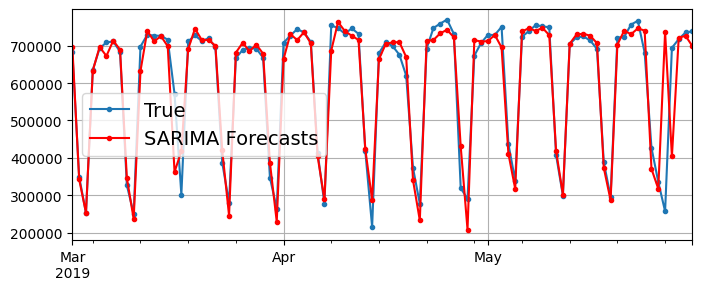

In [27]:
# displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

#### How to pick good hyperparameters for the SARIMA model?

- The simplest method is the brute-force approach: just run a grid search and the model with the lowest MAE (or MSE) wins.

- The Box-Jenkins methodology suggests looking at the autocorrelation function (ACF) and partial autocorrelation function (PACF) to pick $p$ and $q$.

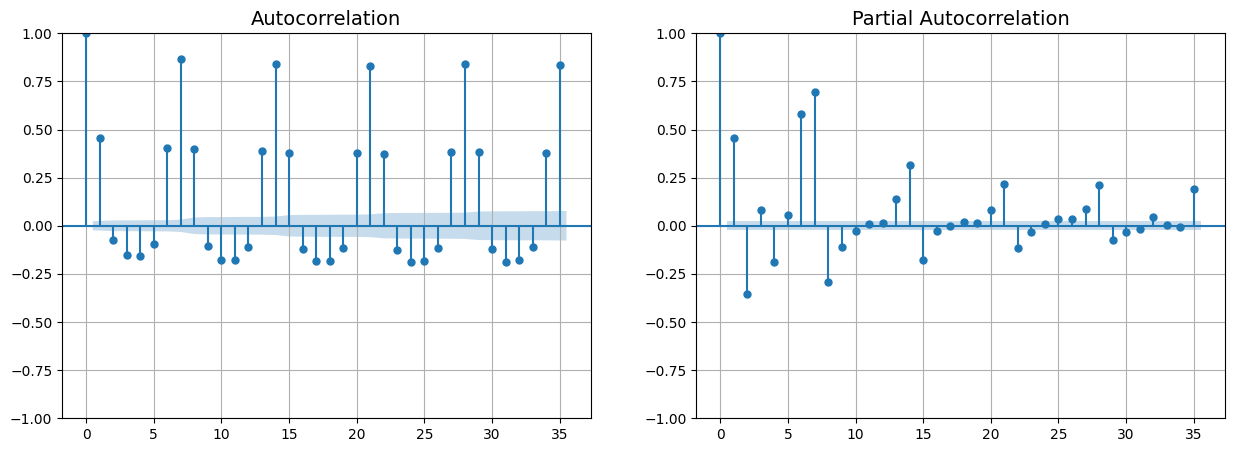

In [28]:
# plot the Autocorrelation Function (ACF) and the
# Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

Here is a nice [case study](https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/) by Jason Brownlee that investigates crime time trends in Boston.
  - It includess DF tests for unit roots and some code to do grid search and cross validatation.


## Preparing the Data for Machine Learning Models

- Our goal will be to forecast tomorrow's ridership based on the ridership of the past 8 weeks of data (56 days) using ML models.

  - The inputs to our model will therefore be sequences, each containing 56 values from time steps $t-55$ to $t$.
  - For each input sequence, the model will output a single value: the forecast for time step $t+1$.

- The "trick" is that we will use every 56-day
window from the past as training data, and the target for each window will be the
value immediately following it.

- `Keras` has a nice utility function called `tf.keras.utils.timeseries_dataset_from_array()` to help us prepare the training set.
  - It takes a time series as input, and it builds a `tf.data.Dataset` containing all
the windows of the desired length, as well as their corresponding targets.



In [12]:
import tensorflow as tf

# An example
my_series = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[5:],  # the targets are 3 steps into the future
    sequence_length=5,
    batch_size=3
)
for i, d in enumerate(my_dataset):
  print(f"Batch {i+1}")
  print(f"{d[0]=}")
  print(f"{d[1]=}")
  print("-------------")

Batch 1
d[0]=<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6]])>
d[1]=<tf.Tensor: shape=(3,), dtype=int32, numpy=array([5, 6, 7])>
-------------
Batch 2
d[0]=<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8],
       [5, 6, 7, 8, 9]])>
d[1]=<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 8,  9, 10])>
-------------
Batch 3
d[0]=<tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[ 6,  7,  8,  9, 10]])>
d[1]=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([11])>
-------------


In [14]:
# An alternative way using windows
for window in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True):
  for element in window:
    print(f"{element}", end=" ")
  print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


The `window()` method returns a nested dataset, analogous to a list of lists.
  - This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them).
  - However, our model expects tensors as input, not datasets. Therefore, we must call the `flat_map()` method: it converts a nested dataset into a flat dataset.
  - `flat_map()` takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening.

In [16]:
dataset = tf.data.Dataset.range(6).window(4, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
  print(f"{window_tensor}")

[0 1 2 3]
[2 3 4 5]


A little helper function to make it easier to extract windows from a dataset:

In [38]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [33]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [17]:
# Split and rescale rail data
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [18]:
rail_train.to_numpy().shape

(1096,)

We'll use `tf.keras.utils.timeseries_dataset_from_array()` to create datasets for training and validation.
  - We shuffle the training windows to achieve something closer to IID samples.

In [19]:
seq_length = 56   # 56 day window
tf.random.set_seed(42)  # ensures reproducibility

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),              # drop time index
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

#### Forecasting Using a Linear Model

- A basic linear model with Huber loss, which usually works better than minimizing the MAE directly.

-  We'll use early stopping:

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=500,
                    callbacks=[early_stopping_cb])

In [38]:
# evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 17ms/step - loss: 0.0023 - mae: 0.0377


37671.14877700806

## Using a Simple RNN

- the most basic RNN, containing a single recurrent layer with just one
recurrent neuron:

In [20]:
tf.random.set_seed(42)  # ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [31]:
model.layers[0](np.array([[[0.], [1.], [2.]]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9296117]], dtype=float32)>

All recurrent layers in Keras expect 3D inputs of shape `[batch size, time steps, dimensionality]`, where dimensionality is 1 for univariate time series and more for multivariate
time series.

  - Recall that `input_shape` ignores the first dimension (i.e., the batch size), and since recurrent layers can accept input sequences of any length, we can set the second dimension to None, which means “any size”.

  - Therefore `input_shape=[None, 1]` means “univariate sequences of any length”.

This model works exactly as we saw earlier:

  1. the initial state $h_{(init)}$ is set to $0$, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_{(0)}$.
  2. The neuron computes a weighted sum of these values plus the bias term, and it applies the activation function to the result, using the hyperbolic tangent function by default.
  3. The result is the first output, $y_0$. In a simple RNN, this output is also the new state $h_0$. This new state is passed to the same recurrent neuron along with the next input value, $x_{(1)}$, and the process is repeated until the last time step.
  4. At the end, the layer just outputs the last value: $y_{55}$.

#### By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set `return_sequences=True`.

In [28]:
# helper function we'll reuse several times

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [ ]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

The performance is OK but not great:

  - The model only has a single recurrent neuron with very limited memory (only 3 parameters!).
  - The activation function is not appropriate: $\tanh(z)\in (-1,1)$

In [42]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [ ]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

## Deep RNNs

- It is quite common to stack multiple layers of cells: a deep RNN.

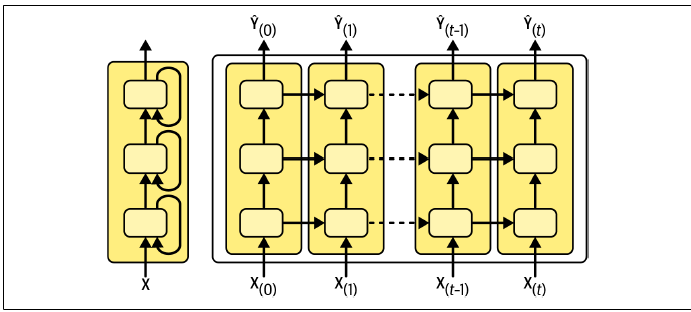

Implementing a deep RNN with `Keras` is straightforward: just stack recurrent layers.

- The first layers should be *sequence-to-sequence* layers, and the last one is
a *sequence-to-vector* layer.



In [11]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

NameError: name 'fit_and_evaluate' is not defined

## Multivariate time series

A great quality of neural networks is their flexibility: in particular, they can deal with
multivariate time series with almost no change to their architecture.

  - For example, let's try to forecast the rail time series using both the bus and rail data as input. In fact, let's also throw in the day type!

In [10]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

NameError: name 'df' is not defined

In [33]:
df_mulvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7639 entries, 2001-01-01 to 2021-11-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bus              7639 non-null   float64
 1   rail             7639 non-null   float64
 2   next_day_type_A  7639 non-null   uint8  
 3   next_day_type_U  7639 non-null   uint8  
 4   next_day_type_W  7639 non-null   uint8  
dtypes: float64(2), uint8(3)
memory usage: 459.5 KB


In [34]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [35]:
tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [36]:
tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), # note the new input shape!
    tf.keras.layers.Dense(1)
])

In [ ]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

It's not too hard to make the RNN forecast both the bus and rail ridership.
  - Change the targets when creating the datasets, setting them to `mulvar_train[["bus", "rail"]][seq_length:]`.
  - Add an extra neuron in the output `Dense` layer, since it must now make two forecasts: one for tomorrow's bus ridership, and the other for rail.

In [ ]:
# build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

In [53]:
# evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [54]:
# evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
  mae = 1e6 * tf.keras.metrics.mean_absolute_error(
      mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
  print(name, int(mae))

3/3 [==============================] - 0s 10ms/step
bus 25786
rail 23322


## Forecasting Several Steps Ahead

What if we want to predict the next 14 values instead of just the value at the next time step?

- The simplest option is to take the `univar_model` RNN we trained earlier for the rail time series, make it predict the next value, and add that value to the inputs, acting as if the predicted value had actually occurred; we would then use the model again to predict the following value, and so on, as in the following code:

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

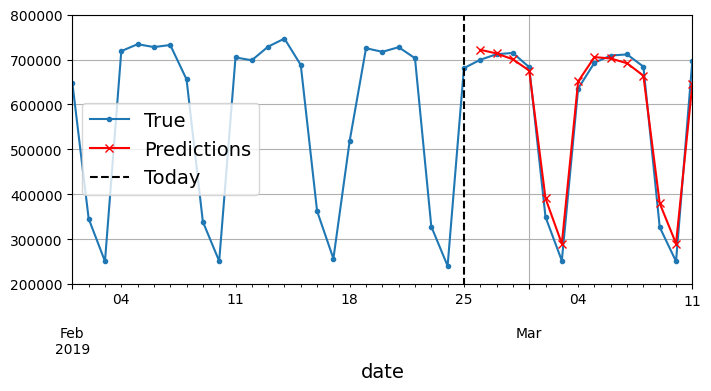

In [56]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

#### If the model makes an error at one time step, then the forecasts for the following time steps are impacted as well: the errors tend to accumulate.

- An alternative is to create an RNN that predicts all 14 next values at once.

  - We need to change the targets to be vectors containing the next 14 values.
  - We can use `timeseries_dataset_from_array()` without targets (`targets=None`) and with longer sequences of length `seq_length+14`. Then we can use the `map()` method to split the sequences into inputs and targets.

In [57]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

Now we need the output layer to have 14 units:

In [58]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

In [61]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]
print(Y_pred)

1/1 [==============================] - 0s 113ms/step
[[0.73465693 0.7069331  0.7308086  0.6902681  0.365865   0.29277706
  0.641292   0.7093709  0.7248462  0.75723207 0.68859    0.37610954
  0.277866   0.6402817 ]]


### Forecasting Using a Sequence-to-Sequence Model

- Instead of training a model to forecast the next 14 values only at the very last time step, we can train an RNN that predicts the next 14 steps at each and every time step.

  - i.e. turn the seq2vec model into a seq2seq model

  - instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, we will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally we will forecast time steps 56 to 69 at the last time step.
  
- The advantage of this technique is that the loss will contain a term for the output of
the RNN at each and every time step, not just for the output at the last time step.

Preparing the datasets is not trivial, since each instance has a window as input and
a sequence of windows as output.

- We can use the `to_windows()` function we created earlier, twice in a row, to get windows of consecutive windows.
- For example, let's turn the series of numbers 0 to 6 into a dataset containing sequences of 4 consecutive windows, each of length 3:


In [39]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(my_series, 3)
print(list(dataset))
print("-------------------")

dataset = to_windows(dataset, 4)
print(list(dataset))

[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 1, 2], dtype=int64)>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3], dtype=int64)>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 3, 4], dtype=int64)>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 4, 5], dtype=int64)>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([4, 5, 6], dtype=int64)>]
-------------------
[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]], dtype=int64)>, <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]], dtype=int64)>]


Then we can split these elements into the desired inputs and targets:

In [40]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

Now the dataset contains sequences of length 4 as inputs, and the targets are sequences
containing the next two steps, for each time step.

- Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [41]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
  # The first windowing is over the forecasts
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  # The second windowing is over seq_length
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(buffer_size=8*batch_size, seed=seed)
  return ds.batch(batch_size)

In [42]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
for el in seq2seq_train.take(1):
    print(el)

In [67]:
tf.random.set_seed(42)
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,
                              return_sequences=True,
                              input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

During training, all the model’s outputs are
used, but after training only the output of the very last time step matters, and the rest
can be ignored.

In [46]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output
print(y_pred_14)

NameError: name 'seq2seq_model' is not defined

In [70]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
  preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                    index=mulvar_valid.index[56 + ahead : -14 + ahead])
  mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
  print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 26ms/step
MAE for +1: 24,929
MAE for +2: 28,978
MAE for +3: 30,399
MAE for +4: 30,794
MAE for +5: 31,025
MAE for +6: 32,523
MAE for +7: 31,602
MAE for +8: 33,216
MAE for +9: 32,758
MAE for +10: 31,809
MAE for +11: 36,415
MAE for +12: 37,958
MAE for +13: 36,555
MAE for +14: 35,201


## Handling Long Sequences


To train an RNN on long sequences, we must run it over many time steps, making
the unrolled RNN a very deep network!

- Just like any deep neural network it may
suffer from the unstable gradients problem: it may take forever to train, or training may be unstable.

- Moreover, when an RNN processes a
long sequence, it will gradually forget the first inputs in the sequence.

### Fighting the Unstable Gradients Problem

Many of the tricks we used in deep nets to alleviate the unstable gradients problem
can also be used for RNNs: good parameter initialization, faster optimizers, dropout,
and so on.

- However, nonsaturating activation functions (e.g., ReLU) may actually lead the RNN to be even more unstable during training because the same weights are used at every time step.

- The gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use gradient clipping.

- **Batch normalization cannot be used** as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers.



## Deep RNNs with Layer Norm

Another form of normalization often works better with RNNs: layer normalization.


- Layer normalization is very similar to batch normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension.

 One advantage is that it can
compute the required statistics on the fly, at each time step, independently for each
instance. This also means that it behaves the same way during training and testing (as
opposed to BN), and it does not need to use exponential moving averages to estimate
the feature statistics across all instances in the training set, like BN does.

- Like BN, layer normalization learns a scale and an offset parameter for each input.

- To implement layer normalization we need to define a custom memory cell, which is just like a regular layer, except its `call()` method takes two arguments: the `inputs` at the current time step and the hidden `states` from the previous time step.

- The `states` argument is a list containing one or more tensors. In the case
of a simple RNN cell it contains a single tensor equal to the outputs of the previous
time step, but other cells may have multiple state tensors.

In [72]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
  def __init__(self, units, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    # RNN cells must have state_size and output_size attributes
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
    self.layer_norm = tf.keras.layers.LayerNormalization()
    self.activation = tf.keras.activations.get(activation)

  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

In [73]:
tf.random.set_seed(42)
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [74]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 5s 101ms/step - loss: 0.0842 - mae: 0.2901 - val_loss: 0.0169 - val_mae: 0.1414
Epoch 2/5
33/33 [==============================] - 4s 122ms/step - loss: 0.0124 - mae: 0.1274 - val_loss: 0.0120 - val_mae: 0.1105
Epoch 3/5
33/33 [==============================] - 3s 94ms/step - loss: 0.0090 - mae: 0.1033 - val_loss: 0.0091 - val_mae: 0.0973
Epoch 4/5
33/33 [==============================] - 4s 129ms/step - loss: 0.0078 - mae: 0.0936 - val_loss: 0.0086 - val_mae: 0.0939
Epoch 5/5
3/3 [==============================] - 0s 30ms/step - loss: 0.0078 - mae: 0.0894


89373.77482652664

## Tackling the Short-Term Memory Problem

Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN's state contains virtually no trace of the first inputs.

- To tackle this problem, various types of cells with long-term memory have been introduced. They have proven so successful that the basic cells are not used much anymore.

### LSTM cells

The long short-term memory (LSTM) cell can be used very much like a basic cell, except it will
perform much better; training will converge faster, and it will detect longer-term
patterns in the data.

In [75]:
tf.random.set_seed(42)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [76]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 29ms/step - loss: 0.0498 - mae: 0.2399 - val_loss: 0.0189 - val_mae: 0.1590
Epoch 2/5
33/33 [==============================] - 1s 14ms/step - loss: 0.0172 - mae: 0.1568 - val_loss: 0.0176 - val_mae: 0.1436
Epoch 3/5
33/33 [==============================] - 1s 13ms/step - loss: 0.0158 - mae: 0.1498 - val_loss: 0.0167 - val_mae: 0.1397
Epoch 4/5
33/33 [==============================] - 1s 13ms/step - loss: 0.0150 - mae: 0.1458 - val_loss: 0.0160 - val_mae: 0.1363
Epoch 5/5
3/3 [==============================] - 0s 13ms/step - loss: 0.0152 - mae: 0.1339


133921.3103055954

The LSTM cell looks exactly like a regular cell,
except that its state is split into two vectors: $\mathbf h_{(t)}$ and $\mathbf c_{(t)}$.

- You can think of $\mathbf h_{(t)}$ as the short-term state and  $\mathbf c_{(t)}$ as the long-term state.

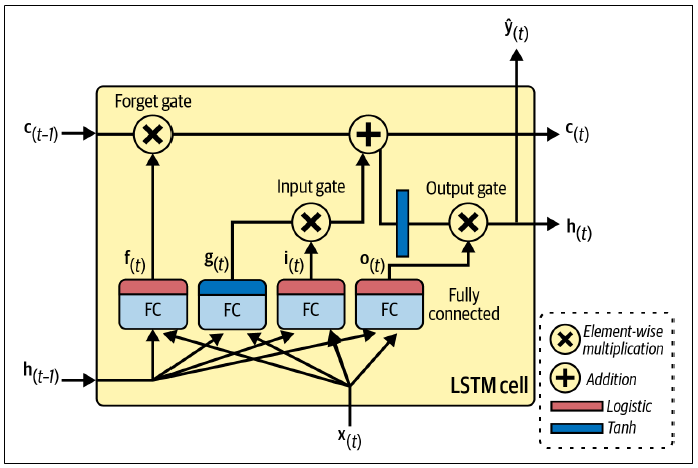


The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it.

  - As the long-term state $\mathbf c_{(t-1)}$ traverses the network from left to right, it first goes through a **forget gate**, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an **input gate**).

  - The result $\mathbf c_{(t)}$ is sent straight out, without any further transformation.
  
  - The long-term state is copied and passed through the $\tanh$ function, and then the result is filtered by the **output gate**. This produces the short-term state $\mathbf h_{(t)}$ (which is equal to the cell's output for this time step, $\mathbf y_{(t)}$).
  
- The current input vector $\mathbf x_{(t)}$ and the previous short-term state $\mathbf h_{(t–1)}$ are fed to four different fully connected layers: the main layer $\mathbf g_{(t)}$ and the three gate controllers ($\mathbf f_{(t)}$, $\mathbf i_{(t)}$, and $\mathbf o_{(t)}$).

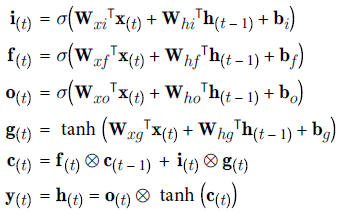

### GRU cells

The gated recurrent unit (GRU) cell is a simplified variant of the LSTM cell that still performs very well.

- Both state vectors are merged into a single vector $\mathbf h_{(t)}$.

- A single gate controller $\mathbf z_{(t)}$ controls both the forget gate and the input gate.
  - If the gate controller outputs a 1, the forget gate is open (= 1) and the input gate
is closed (1 – 1 = 0).

- There is no output gate; the full state vector is output at every time step. However,
there is a new gate controller $\mathbf r_{(t)}$ that controls which part of the previous
state will be shown to the main layer ($\mathbf g_{(t)}$).

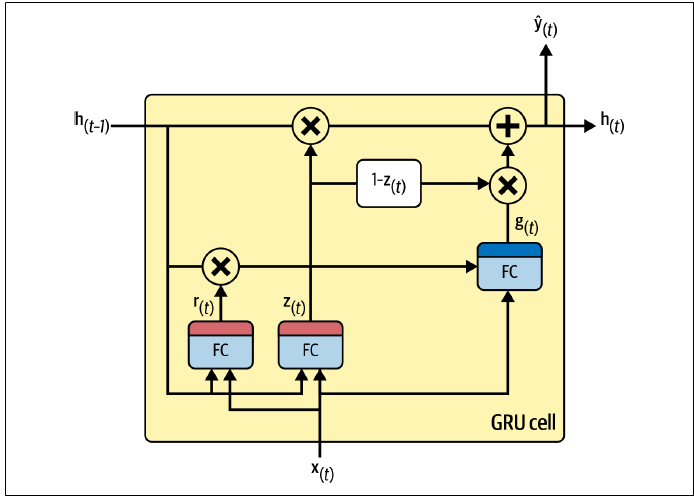

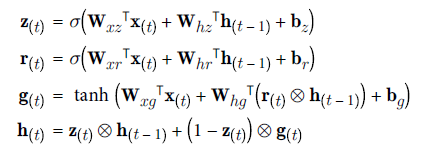

In [77]:
tf.random.set_seed(42)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [78]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 4s 45ms/step - loss: 0.0666 - mae: 0.2766 - val_loss: 0.0173 - val_mae: 0.1545
Epoch 2/5
33/33 [==============================] - 1s 33ms/step - loss: 0.0151 - mae: 0.1412 - val_loss: 0.0145 - val_mae: 0.1281
Epoch 3/5
33/33 [==============================] - 1s 28ms/step - loss: 0.0124 - mae: 0.1286 - val_loss: 0.0132 - val_mae: 0.1212
Epoch 4/5
33/33 [==============================] - 1s 22ms/step - loss: 0.0113 - mae: 0.1219 - val_loss: 0.0122 - val_mae: 0.1171
Epoch 5/5
3/3 [==============================] - 0s 16ms/step - loss: 0.0114 - mae: 0.1138


113807.67822265625

## Using One-Dimensional Convolutional Layers to Process Sequences

LSTMs and GRUs can tackle much longer sequences than simple RNNs, but they still have
a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more, such as audio samples, long time series, or long sentences.

- One way to solve this is to shorten the input sequences; for example, using 1D convolutional layers.

2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps
(one per kernel).
- Similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel.
- Each kernel will learn to detect
a single very short sequential pattern.

- If you use 10 kernels, then the layer's output will be composed of 10 1D sequences, or equivalently you can view this output as a single 10D sequence. This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [ ]:
tf.random.set_seed(42)
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 30ms/step - loss: 0.0482 - mae: 0.2420 - val_loss: 0.0214 - val_mae: 0.1616
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0165 - mae: 0.1532 - val_loss: 0.0171 - val_mae: 0.1423
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0144 - mae: 0.1447 - val_loss: 0.0157 - val_mae: 0.1342
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 0.0130 - mae: 0.1361 - val_loss: 0.0141 - val_mae: 0.1254
Epoch 5/5
1/1 [==============================] - 0s 88ms/step - loss: 0.0124 - mae: 0.1159


115850.42625665665

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 26ms/step - loss: 0.0796 - mae: 0.3159 - val_loss: 0.0239 - val_mae: 0.1723
Epoch 2/5
31/31 [==============================] - 1s 16ms/step - loss: 0.0172 - mae: 0.1585 - val_loss: 0.0182 - val_mae: 0.1545
Epoch 3/5
31/31 [==============================] - 1s 16ms/step - loss: 0.0159 - mae: 0.1561 - val_loss: 0.0181 - val_mae: 0.1505
Epoch 4/5
31/31 [==============================] - 1s 16ms/step - loss: 0.0155 - mae: 0.1535 - val_loss: 0.0175 - val_mae: 0.1479
Epoch 5/5
1/1 [==============================] - 0s 74ms/step - loss: 0.0166 - mae: 0.1407


140713.95993232727

# Extra Material – Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 26ms/step - loss: 0.0706 - mae: 0.2861 - val_loss: 0.0209 - val_mae: 0.1630
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0137 - mae: 0.1398 - val_loss: 0.0140 - val_mae: 0.1273
Epoch 3/5
31/31 [==============================] - 1s 20ms/step - loss: 0.0104 - mae: 0.1190 - val_loss: 0.0116 - val_mae: 0.1125
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0086 - mae: 0.1048 - val_loss: 0.0096 - val_mae: 0.1020
Epoch 5/5
1/1 [==============================] - 0s 71ms/step - loss: 0.0087 - mae: 0.0953


95349.08086061478

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 8.

1. Here are a few RNN applications:
    * For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song
    * For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of _collaborative filtering_ for a recommender system)
    * For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)
2. An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].
3. To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default).
4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with `return_sequences=True` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step _t_, the target should be a vector containing the values at time steps _t_ + 1 to _t_ + 7).
5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem).
6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell. See Figure 15–12.
7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step _t_, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.
8. To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [ ]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065312256/1065301781 [==============================] - 230s 0us/step


In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [ ]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [ ]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.08627451  0.11764706  0.        ]
  [-0.01176471  0.16806725  0.        ]
  [ 0.02352941  0.07563025  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.04705882 -0.06696428  0.        ]
  [-0.09019607 -0.07142857  0.        ]
  [-0.0862745  -0.04464286  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [ 0.00784314  0.11320752  0.        ]
  ...
  [ 0.11764708  0.01886791  0.        ]
  [-0.03529412  0.12264156  0.        ]
  [-0.19215688  0.33962262  1.        ]]

 ...

 [[-0.21276593 -0.01960784  0.        ]
  [-0.31382978  0.00784314  0.        ]
  [-0.37234044  0.13725491  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

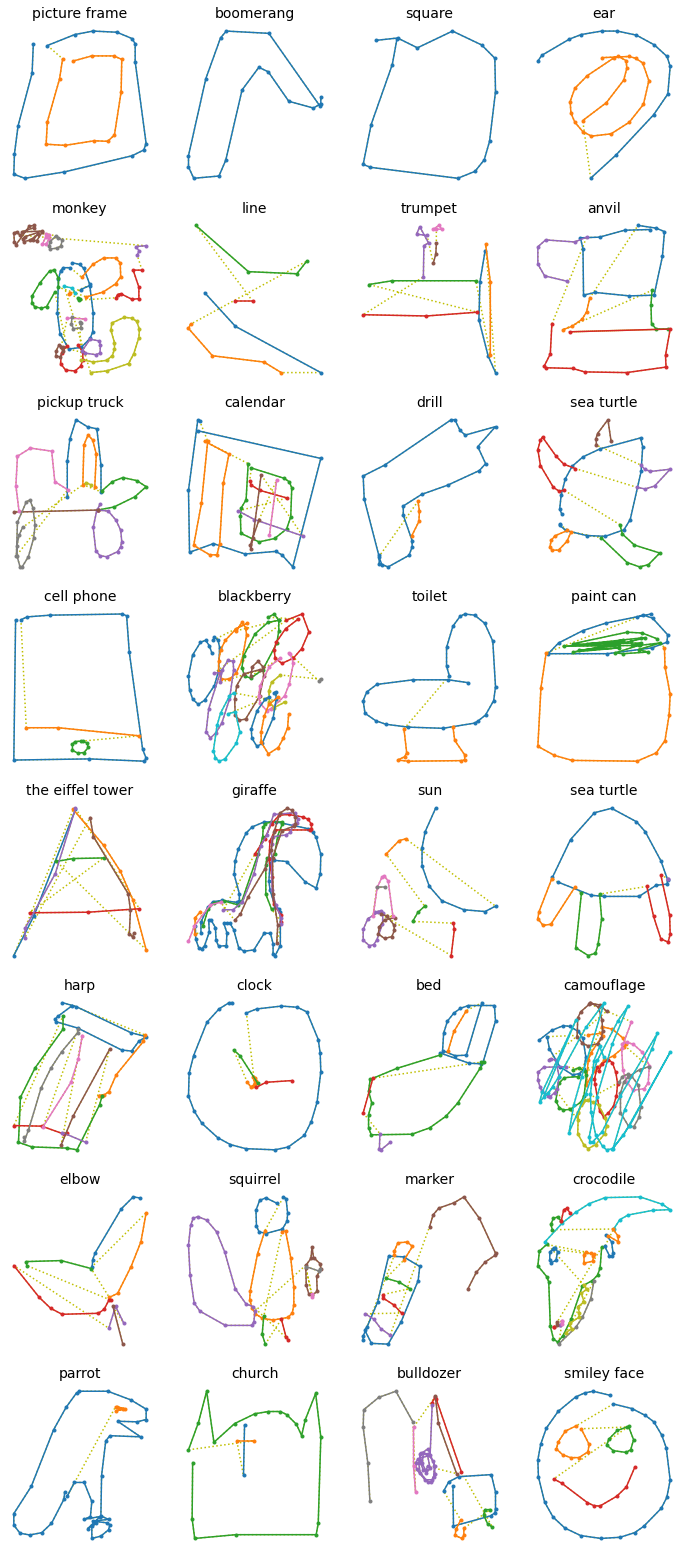

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

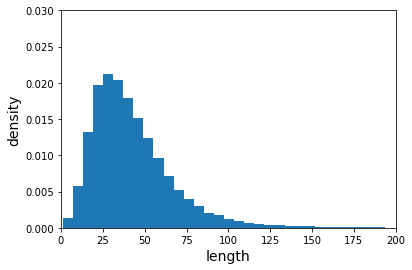

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2048s 19ms/step - loss: 4.0817 - accuracy: 0.1705 - sparse_top_k_categorical_accuracy: 0.3747 - val_loss: 3.0628 - val_accuracy: 0.3127 - val_sparse_top_k_categorical_accuracy: 0.5969
Epoch 2/2
107813/107813 [==============================] - 3975s 37ms/step - loss: 2.7176 - accuracy: 0.3771 - sparse_top_k_categorical_accuracy: 0.6660 - val_loss: 2.4580 - val_accuracy: 0.4253 - val_sparse_top_k_categorical_accuracy: 0.7143


In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.60668993

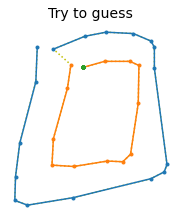

Top-5 predictions:
  1. popsicle 13.105%
  2. computer 7.943%
  3. television 7.032%
  4. laptop 6.640%
  5. cell phone 5.520%
Answer: picture frame


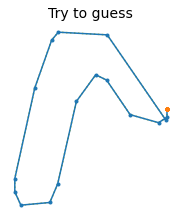

Top-5 predictions:
  1. garden hose 15.217%
  2. trumpet 10.083%
  3. rifle 8.203%
  4. spoon 5.367%
  5. moustache 4.533%
Answer: boomerang


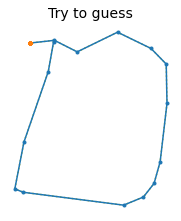

Top-5 predictions:
  1. wine bottle 24.326%
  2. hexagon 22.632%
  3. octagon 13.903%
  4. lipstick 2.759%
  5. blackberry 2.112%
Answer: square


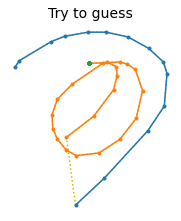

Top-5 predictions:
  1. ear 62.866%
  2. moon 17.284%
  3. boomerang 3.729%
  4. knee 2.912%
  5. squiggle 2.257%
Answer: ear


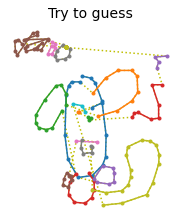

Top-5 predictions:
  1. monkey 34.293%
  2. mermaid 8.274%
  3. blueberry 7.341%
  4. camouflage 4.992%
  5. bear 4.961%
Answer: monkey


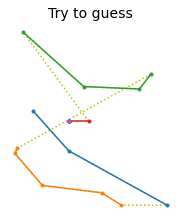

Top-5 predictions:
  1. fork 8.643%
  2. shovel 7.149%
  3. syringe 6.684%
  4. screwdriver 5.352%
  5. stitches 4.247%
Answer: line


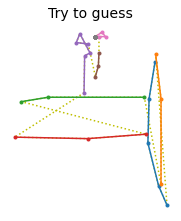

Top-5 predictions:
  1. snowflake 22.972%
  2. yoga 10.533%
  3. matches 6.915%
  4. candle 4.574%
  5. syringe 3.947%
Answer: trumpet


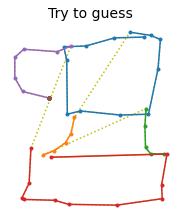

Top-5 predictions:
  1. shovel 15.070%
  2. floor lamp 10.788%
  3. screwdriver 10.516%
  4. lipstick 9.559%
  5. lantern 7.887%
Answer: anvil


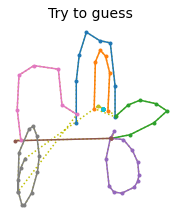

Top-5 predictions:
  1. blueberry 13.230%
  2. submarine 11.078%
  3. bicycle 9.777%
  4. motorbike 9.246%
  5. eyeglasses 8.239%
Answer: pickup truck


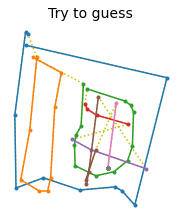

Top-5 predictions:
  1. stereo 21.389%
  2. radio 16.453%
  3. yoga 9.803%
  4. ant 6.983%
  5. power outlet 4.575%
Answer: calendar


In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn", save_format="tf")

2022-02-18 16:47:16.114014: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_sketchrnn/assets


INFO:tensorflow:Assets written to: my_sketchrnn/assets


## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [ ]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

131072/117793 [=================================] - 0s 0us/step


'./datasets/jsb_chorales.tgz'

In [ ]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    tf.keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 conv1d_22 (Conv1D)          (None, None, 32)          352       
                                                                 
 batch_normalization_3 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_23 (Conv1D)          (None, None, 48)          3120      
                                                                 
 batch_normalization_4 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_24 (Conv1D)          (None, None, 64)        

Now we're ready to compile and train the model!

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 25s 208ms/step - loss: 1.8695 - accuracy: 0.5301 - val_loss: 3.7034 - val_accuracy: 0.1226
Epoch 2/20
98/98 [==============================] - 22s 225ms/step - loss: 0.9034 - accuracy: 0.7638 - val_loss: 3.4941 - val_accuracy: 0.1050
Epoch 3/20
98/98 [==============================] - 23s 233ms/step - loss: 0.7523 - accuracy: 0.7916 - val_loss: 3.3243 - val_accuracy: 0.1938
Epoch 4/20
98/98 [==============================] - 23s 232ms/step - loss: 0.6756 - accuracy: 0.8074 - val_loss: 2.5097 - val_accuracy: 0.3022
Epoch 5/20
98/98 [==============================] - 22s 223ms/step - loss: 0.6188 - accuracy: 0.8193 - val_loss: 1.7532 - val_accuracy: 0.4628
Epoch 6/20
98/98 [==============================] - 23s 237ms/step - loss: 0.5788 - accuracy: 0.8280 - val_loss: 1.0323 - val_accuracy: 0.6826
Epoch 7/20
98/98 [==============================] - 25s 256ms/step - loss: 0.5396 - accuracy: 0.8374 - val_loss: 0.7257 - val_accuracy: 0.7910

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [ ]:
model.save("my_bach_model", save_format="tf")
model.evaluate(test_set)

34/34 [==============================] - 3s 74ms/step - loss: 0.6631 - accuracy: 0.8164


[0.6630987524986267, 0.8163789510726929]

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict(arpegio, verbose=0).argmax(axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")